In [1]:
# import necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.applications import VGG19
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.regularizers import L2
import keras.backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import shutil
import math

In [2]:
# Keras removed it's f1 score for some reason

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [93]:
#Import VGG19
new_input = Input(shape=(128, 128, 3))
base_model = VGG19(include_top=False, input_tensor=new_input,weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=[get_f1])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
# Create the datasets
trains_ds=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\labeled\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
valid_ds=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\labeled\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 788 files belonging to 2 classes.
Using 631 files for training.
Found 788 files belonging to 2 classes.
Using 157 files for validation.


In [134]:
# Finally, fit the model!
history=model.fit(trains_ds, epochs=5, validation_data=valid_ds)

Epoch 1/5
20/20 [==============================] - 28s 1s/step - loss: 2.9179 - get_f1: 0.6516 - val_loss: 1.2184 - val_get_f1: 0.7789
Epoch 2/5
20/20 [==============================] - 28s 1s/step - loss: 1.8156 - get_f1: 0.7335 - val_loss: 0.9719 - val_get_f1: 0.7197
Epoch 3/5
20/20 [==============================] - 25s 1s/step - loss: 1.1014 - get_f1: 0.7403 - val_loss: 0.7410 - val_get_f1: 0.7905
Epoch 4/5
20/20 [==============================] - 30s 2s/step - loss: 0.9065 - get_f1: 0.7415 - val_loss: 0.6786 - val_get_f1: 0.7906
Epoch 5/5
20/20 [==============================] - 27s 1s/step - loss: 0.6714 - get_f1: 0.7756 - val_loss: 0.6603 - val_get_f1: 0.8073


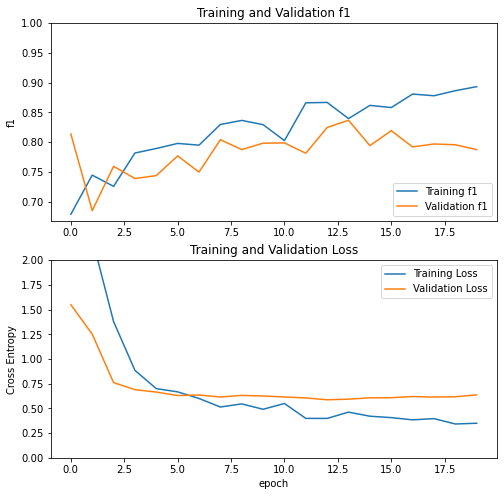

In [18]:
# How does the model do over the eopchs?
# This will be our baseline to see if we can improve on this
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training f1')
plt.plot(val_acc, label='Validation f1')
plt.legend(loc='lower right')
plt.ylabel('f1')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [92]:
# Now we try to fine tune the model
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[get_f1])

model.summary()

NameError: name 'base_model' is not defined

In [17]:
history_fine = model.fit(trains_ds, epochs=24,initial_epoch=history.epoch[14],validation_data=valid_ds)

Epoch 15/24
20/20 [==============================] - 40s 2s/step - loss: 0.3295 - get_f1: 0.8987 - val_loss: 0.6488 - val_get_f1: 0.8149
Epoch 16/24
20/20 [==============================] - 32s 2s/step - loss: 0.2936 - get_f1: 0.8946 - val_loss: 0.6751 - val_get_f1: 0.8095
Epoch 17/24
20/20 [==============================] - 32s 2s/step - loss: 0.2819 - get_f1: 0.9100 - val_loss: 0.6714 - val_get_f1: 0.8159
Epoch 18/24
20/20 [==============================] - 32s 2s/step - loss: 0.2542 - get_f1: 0.9144 - val_loss: 0.6867 - val_get_f1: 0.8143
Epoch 19/24
20/20 [==============================] - 36s 2s/step - loss: 0.2690 - get_f1: 0.9209 - val_loss: 0.7076 - val_get_f1: 0.8037
Epoch 20/24
20/20 [==============================] - 36s 2s/step - loss: 0.1817 - get_f1: 0.9459 - val_loss: 0.7288 - val_get_f1: 0.8133
Epoch 21/24
20/20 [==============================] - 34s 2s/step - loss: 0.2021 - get_f1: 0.9345 - val_loss: 0.7314 - val_get_f1: 0.8060
Epoch 22/24
20/20 [======================

In [19]:
f1 += history_fine.history['get_f1']
val_f1 += history_fine.history['val_get_f1']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

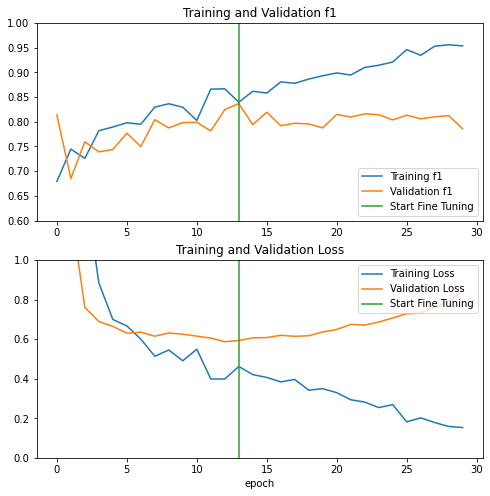

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1, label='Training f1')
plt.plot(val_f1, label='Validation f1')
plt.ylim([0.6, 1])
plt.plot([14-1,14-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation f1')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([14-1,14-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

So it seems that fine tuning the model causes overfitting!

With this as our base line we will try to develop new labels for all of our data to expand our dataset. To do this, we will try to develop a model on the data that is present for all data points (the title, description, comments on the video). 

In [79]:
# labels data 

# ID and labels
labels=pd.read_csv(r'..\data\raw\data_labels.csv')
for col in labels:
    #get dtype for column
    dt = labels[col].dtype 
    #check if it is a number
    if dt == int or dt == float:
        labels[col].fillna(0,inplace=True)
    else:
        labels[col].fillna(" ",inplace=True)
# Other features

labels_large=pd.read_csv(r'..\data\raw\data_labels_large.csv',lineterminator='\n')
for col in labels_large:
    #get dtype for column
    dt = labels_large[col].dtype 
    #check if it is a number
    if dt == int or dt == float:
        labels_large[col].fillna(0,inplace=True)
    else:
        labels_large[col].fillna(" ",inplace=True)
        
# Create a table with features and labels 
full_labels=pd.merge(labels,labels_large,how='left',on='ID')
full_labels['label']=full_labels['label'].apply(lambda x: 1 if x=='clickbait' else 0)
full_labels['comment'] = full_labels[['comment_0','comment_1', 'comment_2', 'comment_3', 'comment_4', 'comment_5', 'comment_6', 'comment_7', 'comment_8', 'comment_9']].agg(' '.join, axis=1)

In [82]:
def objective(trial):
    
    X=full_labels[['title_x','channel_label','description','comment','dislikeCount','favoriteCount','likeCount','viewCount']]
    X.reset_index(drop=True, inplace=True)
    y=full_labels['label']
    
    preprocessor = ColumnTransformer(transformers = [('TFIDIF_title', TfidfVectorizer(),'title_x'),
                                                     ('TFIDIF_desc', TfidfVectorizer(),'description'),
                                                     ('TFIDIF_comment', TfidfVectorizer(),'comment')])
    
    parameter = {
      'max_depth':trial.suggest_int('max_depth', 3, 5), # show integer parameters between 3 and 5 for depth
      'learning_rate':trial.suggest_float('learning_rate',0.05,0.6,log=True), # set a log distribution between 0.05 and 0.5 for learning rate
      'colsample_bytree':trial.suggest_float('colsample_bytree',0.4,0.9), # set a uniformly distributed numbers between 0.4 and 0.9 for colsample_bytree
      'subsample':trial.suggest_float('subsample',0.4,0.9),
      "gamma":trial.suggest_float('gamma',0,1),
      "reg_lambda": trial.suggest_int('reg_lambda',0,10),
      "scale_pos_weight": trial.suggest_int('scale_pos_weight',0,10),
      "eta":trial.suggest_float("eta", 1e-8, 1.0,log=True),
      "min_child_weight":trial.suggest_float('min_child_weight',1e-2, 1e2,log=True)
    }
    
    pipeline = Pipeline([('preprocessor', preprocessor),
    ("classifier", xgb.XGBClassifier(**parameter))
    ])

    return np.mean(cross_val_score(pipeline, X, y,scoring='f1',cv=10))


In [83]:
study = optuna.create_study(direction='maximize',study_name='label_generator_tuning')
study.optimize(objective,n_trials=200)

[I 2022-09-30 20:00:48,196] A new study created in memory with name: label_generator_tuning
[I 2022-09-30 20:00:52,929] Trial 0 finished with value: 0.5906206926990546 and parameters: {'max_depth': 4, 'learning_rate': 0.16811280407874185, 'colsample_bytree': 0.732424775389741, 'subsample': 0.7669231790020878, 'gamma': 0.9491796249916685, 'reg_lambda': 10, 'scale_pos_weight': 1, 'eta': 1.2772993008704756e-05, 'min_child_weight': 3.5019927257273133}. Best is trial 0 with value: 0.5906206926990546.
[I 2022-09-30 20:00:58,454] Trial 1 finished with value: 0.595659944752388 and parameters: {'max_depth': 4, 'learning_rate': 0.18674772483170174, 'colsample_bytree': 0.7845222246746948, 'subsample': 0.5864880628296104, 'gamma': 0.34333943961814617, 'reg_lambda': 2, 'scale_pos_weight': 4, 'eta': 0.000888294498985221, 'min_child_weight': 0.010089689211398394}. Best is trial 1 with value: 0.595659944752388.
[I 2022-09-30 20:01:02,559] Trial 2 finished with value: 0.31177034937056824 and parameters

[I 2022-09-30 20:02:24,141] Trial 20 finished with value: 0.63997886282821 and parameters: {'max_depth': 3, 'learning_rate': 0.14058405912354502, 'colsample_bytree': 0.5053889110815222, 'subsample': 0.7351240985034614, 'gamma': 0.8141622658203167, 'reg_lambda': 6, 'scale_pos_weight': 6, 'eta': 0.8783007293739126, 'min_child_weight': 0.20216410048017458}. Best is trial 14 with value: 0.6443489106492817.
[I 2022-09-30 20:02:28,365] Trial 21 finished with value: 0.6335467765270243 and parameters: {'max_depth': 3, 'learning_rate': 0.1397602478399226, 'colsample_bytree': 0.5140805305418176, 'subsample': 0.7635994126640859, 'gamma': 0.801454418645674, 'reg_lambda': 6, 'scale_pos_weight': 6, 'eta': 0.9983826001518757, 'min_child_weight': 0.16614258226754436}. Best is trial 14 with value: 0.6443489106492817.
[I 2022-09-30 20:02:32,787] Trial 22 finished with value: 0.6383557520989688 and parameters: {'max_depth': 3, 'learning_rate': 0.08549634917079178, 'colsample_bytree': 0.6078413522633771, 

[I 2022-09-30 20:03:55,490] Trial 40 finished with value: 0.5843017137334569 and parameters: {'max_depth': 3, 'learning_rate': 0.07152031283132974, 'colsample_bytree': 0.8430566831529365, 'subsample': 0.842708543645688, 'gamma': 0.32834899547770013, 'reg_lambda': 1, 'scale_pos_weight': 1, 'eta': 0.00033835104272459423, 'min_child_weight': 2.011159832275168}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:04:00,405] Trial 41 finished with value: 0.619289222779357 and parameters: {'max_depth': 3, 'learning_rate': 0.05571991587739323, 'colsample_bytree': 0.7238080012380507, 'subsample': 0.8706371291693432, 'gamma': 0.475169922113359, 'reg_lambda': 0, 'scale_pos_weight': 2, 'eta': 9.414744248457536e-08, 'min_child_weight': 1.0140002942448507}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:04:05,487] Trial 42 finished with value: 0.6398508851870804 and parameters: {'max_depth': 3, 'learning_rate': 0.058727398471579054, 'colsample_bytree': 0.77387918682

[I 2022-09-30 20:05:26,848] Trial 60 finished with value: 0.647114284959261 and parameters: {'max_depth': 5, 'learning_rate': 0.07149903004893418, 'colsample_bytree': 0.661892624855612, 'subsample': 0.8141748045239008, 'gamma': 0.6175088800791795, 'reg_lambda': 4, 'scale_pos_weight': 5, 'eta': 0.001215452089330402, 'min_child_weight': 0.28778500036063875}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:05:32,529] Trial 61 finished with value: 0.6378415159002231 and parameters: {'max_depth': 5, 'learning_rate': 0.06982239609901485, 'colsample_bytree': 0.6680517089531686, 'subsample': 0.8163133810734176, 'gamma': 0.6134681690530499, 'reg_lambda': 3, 'scale_pos_weight': 5, 'eta': 0.001179070217787786, 'min_child_weight': 0.282836428610106}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:05:38,342] Trial 62 finished with value: 0.6399127672858548 and parameters: {'max_depth': 5, 'learning_rate': 0.05549995176170933, 'colsample_bytree': 0.58771516701515

[I 2022-09-30 20:07:02,891] Trial 80 finished with value: 0.0 and parameters: {'max_depth': 3, 'learning_rate': 0.06747211259711898, 'colsample_bytree': 0.5522289272432632, 'subsample': 0.8393660691478319, 'gamma': 0.48588287290230225, 'reg_lambda': 1, 'scale_pos_weight': 0, 'eta': 0.005291903136266937, 'min_child_weight': 0.27199156473313574}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:07:07,302] Trial 81 finished with value: 0.6297769978500202 and parameters: {'max_depth': 3, 'learning_rate': 0.06153501344520057, 'colsample_bytree': 0.6033048939420149, 'subsample': 0.8651883123991053, 'gamma': 0.1705830301000221, 'reg_lambda': 0, 'scale_pos_weight': 2, 'eta': 3.1512499789604424e-06, 'min_child_weight': 0.7583488310537523}. Best is trial 28 with value: 0.6577729672325274.
[I 2022-09-30 20:07:11,549] Trial 82 finished with value: 0.6473407816809429 and parameters: {'max_depth': 3, 'learning_rate': 0.05014445930371707, 'colsample_bytree': 0.48541143522208274, 'sub

[I 2022-09-30 20:08:22,680] Trial 100 finished with value: 0.5812414799782883 and parameters: {'max_depth': 3, 'learning_rate': 0.28537182363123786, 'colsample_bytree': 0.4632494837013446, 'subsample': 0.5414340630202727, 'gamma': 0.19984343349911562, 'reg_lambda': 1, 'scale_pos_weight': 3, 'eta': 0.6837928613105412, 'min_child_weight': 5.541682718460925}. Best is trial 91 with value: 0.6661001100686061.
[I 2022-09-30 20:08:26,576] Trial 101 finished with value: 0.6566484192991331 and parameters: {'max_depth': 3, 'learning_rate': 0.05923660929183871, 'colsample_bytree': 0.5108664174634788, 'subsample': 0.8727118833145604, 'gamma': 0.14024937748231833, 'reg_lambda': 1, 'scale_pos_weight': 3, 'eta': 0.2733308773310793, 'min_child_weight': 7.302083196273677}. Best is trial 91 with value: 0.6661001100686061.
[I 2022-09-30 20:08:30,566] Trial 102 finished with value: 0.6513212863528709 and parameters: {'max_depth': 3, 'learning_rate': 0.06546917391447421, 'colsample_bytree': 0.4719699354305

[I 2022-09-30 20:09:39,296] Trial 120 finished with value: 0.6556925449867107 and parameters: {'max_depth': 3, 'learning_rate': 0.053554769446174745, 'colsample_bytree': 0.445020958651259, 'subsample': 0.865875947097745, 'gamma': 0.08521875079794886, 'reg_lambda': 2, 'scale_pos_weight': 3, 'eta': 0.035457851043837446, 'min_child_weight': 2.6741351641325553}. Best is trial 113 with value: 0.6680455047949372.
[I 2022-09-30 20:09:43,135] Trial 121 finished with value: 0.6615245371669947 and parameters: {'max_depth': 3, 'learning_rate': 0.06200930171963462, 'colsample_bytree': 0.4531775294991358, 'subsample': 0.8509775259568916, 'gamma': 0.1557558433346669, 'reg_lambda': 2, 'scale_pos_weight': 3, 'eta': 0.8554444528677433, 'min_child_weight': 2.335790276675123}. Best is trial 113 with value: 0.6680455047949372.
[I 2022-09-30 20:09:46,971] Trial 122 finished with value: 0.6450797073401116 and parameters: {'max_depth': 3, 'learning_rate': 0.061631642469537486, 'colsample_bytree': 0.431283812

[I 2022-09-30 20:10:57,149] Trial 140 finished with value: 0.6597352239544438 and parameters: {'max_depth': 3, 'learning_rate': 0.05833499408367749, 'colsample_bytree': 0.4369160457684509, 'subsample': 0.8998375222284223, 'gamma': 0.18901498875257128, 'reg_lambda': 1, 'scale_pos_weight': 3, 'eta': 0.021798734622842656, 'min_child_weight': 4.993047116885306}. Best is trial 135 with value: 0.6768051064578999.
[I 2022-09-30 20:11:01,070] Trial 141 finished with value: 0.6574276572909705 and parameters: {'max_depth': 3, 'learning_rate': 0.06352183488585082, 'colsample_bytree': 0.45313725589420184, 'subsample': 0.8741386248156725, 'gamma': 0.23510195728201638, 'reg_lambda': 2, 'scale_pos_weight': 3, 'eta': 0.41796338558966584, 'min_child_weight': 2.3918281439261406}. Best is trial 135 with value: 0.6768051064578999.
[I 2022-09-30 20:11:04,919] Trial 142 finished with value: 0.6248114003921263 and parameters: {'max_depth': 3, 'learning_rate': 0.2364291104741002, 'colsample_bytree': 0.4595256

[I 2022-09-30 20:12:15,536] Trial 160 finished with value: 0.6505909758586388 and parameters: {'max_depth': 3, 'learning_rate': 0.06408417041146844, 'colsample_bytree': 0.5133299834338729, 'subsample': 0.8344045968529843, 'gamma': 0.29969691144304866, 'reg_lambda': 1, 'scale_pos_weight': 3, 'eta': 0.047423983155201875, 'min_child_weight': 4.048620078107647}. Best is trial 159 with value: 0.6776551073814285.
[I 2022-09-30 20:12:19,667] Trial 161 finished with value: 0.6547336578550202 and parameters: {'max_depth': 3, 'learning_rate': 0.059478902813012, 'colsample_bytree': 0.4960003989766493, 'subsample': 0.876670774857595, 'gamma': 0.22289016155953964, 'reg_lambda': 1, 'scale_pos_weight': 3, 'eta': 0.09171265085667529, 'min_child_weight': 2.67201084367435}. Best is trial 159 with value: 0.6776551073814285.
[I 2022-09-30 20:12:23,560] Trial 162 finished with value: 0.6638024376206607 and parameters: {'max_depth': 3, 'learning_rate': 0.05499673969424505, 'colsample_bytree': 0.462758438935

[I 2022-09-30 20:13:33,391] Trial 180 finished with value: 0.6612790982602303 and parameters: {'max_depth': 3, 'learning_rate': 0.062352057228188165, 'colsample_bytree': 0.4407696148414576, 'subsample': 0.8431865113466683, 'gamma': 0.20432500773925855, 'reg_lambda': 3, 'scale_pos_weight': 2, 'eta': 0.01003593758862901, 'min_child_weight': 3.2271333377339144}. Best is trial 159 with value: 0.6776551073814285.
[I 2022-09-30 20:13:37,085] Trial 181 finished with value: 0.6577829727993605 and parameters: {'max_depth': 3, 'learning_rate': 0.05631641986129711, 'colsample_bytree': 0.44852008313565417, 'subsample': 0.8593493019451693, 'gamma': 0.17522697745791876, 'reg_lambda': 2, 'scale_pos_weight': 3, 'eta': 0.42971970663661857, 'min_child_weight': 4.368889247110838}. Best is trial 159 with value: 0.6776551073814285.
[I 2022-09-30 20:13:40,919] Trial 182 finished with value: 0.6669853349168943 and parameters: {'max_depth': 3, 'learning_rate': 0.052238835945592914, 'colsample_bytree': 0.42325

In [84]:
X=full_labels[['title_x','channel_label','description','comment','dislikeCount','favoriteCount','likeCount','viewCount']]
X.reset_index(drop=True, inplace=True)
y=full_labels['label']

preprocessor = ColumnTransformer(transformers = [('TFIDIF_title', TfidfVectorizer(),'title_x'),
                                                     ('TFIDIF_desc', TfidfVectorizer(),'description'),
                                                     ('TFIDIF_comment', TfidfVectorizer(),'comment')])

parameters=study.best_trial.params

pipeline = Pipeline([('preprocessor', preprocessor),
    ("classifier", xgb.XGBClassifier(**parameters))
    ])

pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('TFIDIF_title',
                                                  TfidfVectorizer(),
                                                  'title_x'),
                                                 ('TFIDIF_desc',
                                                  TfidfVectorizer(),
                                                  'description'),
                                                 ('TFIDIF_comment',
                                                  TfidfVectorizer(),
                                                  'comment')])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.4962015462...
                               grow_policy='depthwise', importance_type=None,
                               interaction

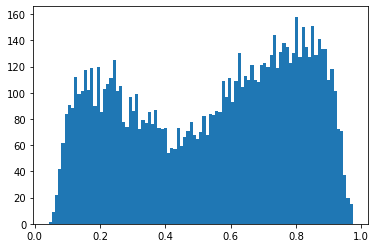

In [87]:
labels_large['comment']=labels_large[['comment_0','comment_1', 'comment_2', 'comment_3', 'comment_4', 'comment_5', 'comment_6', 'comment_7', 'comment_8', 'comment_9']].agg(' '.join, axis=1)
labels_large=labels_large.rename({'title':'title_x'},axis=1)
X_large=labels_large[['title_x','channel_label','description','comment','dislikeCount','favoriteCount','likeCount','viewCount']]
plt.hist([x[0] for x in pipeline.predict_proba(X_large)],bins=95)
y_pred=pipeline.predict(X_large)
y_pred_df=pd.DataFrame({'ID':labels_large['ID'],'label':y_pred})

In [88]:
def get_best_label(ID):
    if ID in list(full_labels['ID']):
        return full_labels[full_labels['ID']==ID]['label'].iloc[0]
    else:
        return y_pred_df[y_pred_df['ID']==ID]['label'].iloc[0]

In [89]:
y_pred_df['best_label']=y_pred_df['ID'].apply(get_best_label)

In [109]:
# Create directories for the labeled data
class_names = [1,0]

#creating subfolders
for i in class_names:
    os.makedirs(os.path.join('..\\data\\interim\\thumbnails\\final_labels_training\\', str(i)))
    os.makedirs(os.path.join('..\\data\\interim\\thumbnails\\final_labels_validation\\', str(i)))

#moving the image files to their respective categories
for i in class_names: # Category Name
    for ID in list(y_pred_df[y_pred_df['best_label']==i]['ID']): # Image Id
        if (ID in list(full_labels['ID'])):
            if (np.random.random()>0.6):
                get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
                copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_validation\\'+str(i))
            else:
                get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
                copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_training\\'+str(i))
        else:
            get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
            copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_training\\'+str(i))

In [90]:
train_ds_final=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\final_labels_training\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
valid_ds_final=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\final_labels_validation\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 8651 files belonging to 2 classes.
Found 336 files belonging to 2 classes.


In [94]:
history_big=model.fit(train_ds_final, epochs=10, validation_data=valid_ds_final)

Epoch 1/10
271/271 [==============================] - 260s 957ms/step - loss: 1.1757 - get_f1: 0.5700 - val_loss: 0.6171 - val_get_f1: 0.5470
Epoch 2/10
271/271 [==============================] - 260s 961ms/step - loss: 0.6039 - get_f1: 0.6427 - val_loss: 0.6132 - val_get_f1: 0.5511
Epoch 3/10
271/271 [==============================] - 243s 897ms/step - loss: 0.5774 - get_f1: 0.6679 - val_loss: 0.6076 - val_get_f1: 0.5493
Epoch 4/10
271/271 [==============================] - 287s 1s/step - loss: 0.5632 - get_f1: 0.6781 - val_loss: 0.6060 - val_get_f1: 0.5342
Epoch 5/10
271/271 [==============================] - 273s 1s/step - loss: 0.5463 - get_f1: 0.6863 - val_loss: 0.5910 - val_get_f1: 0.5496
Epoch 6/10
271/271 [==============================] - 287s 1s/step - loss: 0.5331 - get_f1: 0.6967 - val_loss: 0.6059 - val_get_f1: 0.5644
Epoch 7/10
271/271 [==============================] - 258s 951ms/step - loss: 0.5347 - get_f1: 0.6963 - val_loss: 0.6175 - val_get_f1: 0.5704
Epoch 8/10
271/

In [4]:
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data
        _len = y.shape[0]
        _alpha = alpha
        _idx = math.floor(_len*_alpha)
        # forward for get loss from every samples
        y_pred = self(x, training=False)  # Forward pass
        loss_ITML = keras.losses.binary_crossentropy(y, y_pred)
        loss_ITML_np = loss_ITML.numpy()
        argsort = np.argsort(loss_ITML_np)
        # get new training data
        x, y = tf.gather(x, argsort[:_idx]), tf.gather(y, argsort[:_idx])
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
           # Compute the loss value
           # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [13]:
# does trimming high-loss labels improve the performance, even if the training is just being done on the original dataset?
# This gives us some idea of how noisy the mechanical turk generated labels are!

new_input = Input(shape=(128, 128, 3))
base_model_trimmer = VGG19(include_top=False, input_tensor=new_input,weights='imagenet')

x = base_model_trimmer.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
# and a logistic layer -- let's say we have 2 classes
predictions_trimmed = Dense(1, activation='sigmoid')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_trimmer.layers:
    layer.trainable = False

model_trimmed = CustomModel(new_input, predictions_trimmed)    

# compile the model (should be done *after* setting layers to non-trainable)
model_trimmed.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[get_f1],run_eagerly=True)

mystery=model_trimmed.fit(trains_ds, epochs=1, validation_data=valid_ds)

20/20 [==============================] - 153s 8s/step - loss: 1.4885 - get_f1: 0.8500 - val_loss: 1.8748 - val_get_f1: 0.7315


In [32]:
def best_f1_for_alpha():
    new_input = Input(shape=(128, 128, 3))
    base_model_trimmer = VGG19(include_top=False, input_tensor=new_input,weights='imagenet')

    x = base_model_trimmer.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    # and a logistic layer -- let's say we have 2 classes
    predictions_trimmed = Dense(1, activation='sigmoid')(x)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model_trimmer.layers:
        layer.trainable = False

    model_trimmed = CustomModel(new_input, predictions_trimmed)    

    # compile the model (should be done *after* setting layers to non-trainable)
    model_trimmed.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=[get_f1],run_eagerly=True)

    mystery=model_trimmed.fit(trains_ds, epochs=5, validation_data=valid_ds)
    return max(mystery.history['val_get_f1'])

In [27]:
alpha_log=[]
f1_log=[]
for x in np.linspace(0.5,1,11):
    alpha=x
    alpha_log.append(alpha)
    f1_log.append(best_f1_for_alpha())

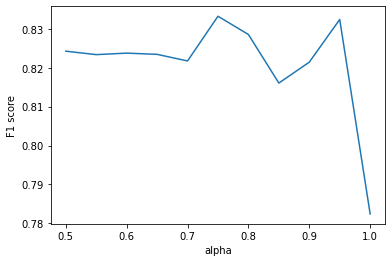

In [31]:
plt.plot(alpha_log,f1_log)
plt.xlabel("alpha")
plt.ylabel("F1 score")
plt.show()

Epoch 1/5
20/20 [==============================] - 114s 6s/step - loss: 1.4422 - get_f1: 0.9228 - val_loss: 9.2703 - val_get_f1: 0.8228
Epoch 2/5
20/20 [==============================] - 144s 7s/step - loss: 0.6393 - get_f1: 0.9697 - val_loss: 4.9926 - val_get_f1: 0.8222
Epoch 3/5
20/20 [==============================] - 145s 7s/step - loss: 0.5720 - get_f1: 0.9520 - val_loss: 5.0607 - val_get_f1: 0.8188
Epoch 4/5
20/20 [==============================] - 120s 6s/step - loss: 0.3813 - get_f1: 0.9736 - val_loss: 4.5071 - val_get_f1: 0.8190
Epoch 5/5
20/20 [==============================] - 120s 6s/step - loss: 0.3024 - get_f1: 0.9643 - val_loss: 3.4112 - val_get_f1: 0.8117
Epoch 1/5
20/20 [==============================] - 131s 7s/step - loss: 1.6123 - get_f1: 0.7908 - val_loss: 5.7539 - val_get_f1: 0.8216
Epoch 2/5
20/20 [==============================] - 135s 7s/step - loss: 0.6875 - get_f1: 0.9542 - val_loss: 2.8723 - val_get_f1: 0.8224
Epoch 3/5
20/20 [==============================]

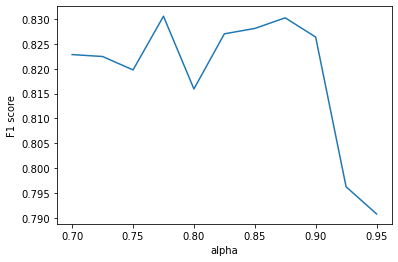

In [33]:
alpha_log_fine=[]
f1_log_fine=[]
for x in np.linspace(0.7,.95,11):
    alpha=x
    alpha_log_fine.append(alpha)
    f1_log_fine.append(best_f1_for_alpha())
    
plt.plot(alpha_log_fine,f1_log_fine)
plt.xlabel("alpha")
plt.ylabel("F1 score")
plt.show()

In [124]:
from sklearn.ensemble import RandomForestClassifier

def objective_forest(trial):
    
    X=full_labels[['title_x','channel_label','description','comment','dislikeCount','favoriteCount','likeCount','viewCount']]
    X.reset_index(drop=True, inplace=True)
    y=full_labels['label']
    
    preprocessor = ColumnTransformer(transformers = [('TFIDIF_title', TfidfVectorizer(),'title_x'),
                                                     ('TFIDIF_desc', TfidfVectorizer(),'description'),
                                                     ('TFIDIF_comment', TfidfVectorizer(),'comment')])
    
    parameter = {
      'n_estimators':trial.suggest_int('n_estimators',2,2000),
      'max_depth':trial.suggest_int('max_depth', 2, 64), # show integer parameters between 3 and 5 for depth
      'class_weight':trial.suggest_categorical('class_weight',[None,'balanced']), # set a log distribution between 0.05 and 0.5 for learning rate
    }
    
    pipeline = Pipeline([('preprocessor', preprocessor),
    ("classifier", RandomForestClassifier(**parameter))
    ])

    return np.mean(cross_val_score(pipeline, X, y,scoring='precision',cv=10))


In [125]:
study_forest = optuna.create_study(direction='maximize',study_name='label_generator_tuning_forest')
study_forest.optimize(objective_forest,n_trials=50)

[I 2022-09-30 23:57:00,564] A new study created in memory with name: label_generator_tuning_forest
[I 2022-09-30 23:57:34,798] Trial 0 finished with value: 0.7235334325117607 and parameters: {'n_estimators': 1569, 'max_depth': 31, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7235334325117607.
[I 2022-09-30 23:57:38,336] Trial 1 finished with value: 0.6708850708115415 and parameters: {'n_estimators': 112, 'max_depth': 44, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7235334325117607.
[I 2022-09-30 23:57:45,952] Trial 2 finished with value: 0.7109521446905347 and parameters: {'n_estimators': 289, 'max_depth': 36, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7235334325117607.
[I 2022-09-30 23:58:02,431] Trial 3 finished with value: 0.7591036088094911 and parameters: {'n_estimators': 1014, 'max_depth': 14, 'class_weight': None}. Best is trial 3 with value: 0.7591036088094911.
[I 2022-09-30 23:58:26,531] Trial 4 finished with value: 0.75007546632933

[I 2022-10-01 00:04:35,342] Trial 29 finished with value: 0.7631248081983376 and parameters: {'n_estimators': 552, 'max_depth': 31, 'class_weight': None}. Best is trial 24 with value: 0.7643737274077831.
[I 2022-10-01 00:04:47,855] Trial 30 finished with value: 0.7348693350778086 and parameters: {'n_estimators': 523, 'max_depth': 47, 'class_weight': None}. Best is trial 24 with value: 0.7643737274077831.
[I 2022-10-01 00:04:56,791] Trial 31 finished with value: 0.7525483013718307 and parameters: {'n_estimators': 387, 'max_depth': 32, 'class_weight': None}. Best is trial 24 with value: 0.7643737274077831.
[I 2022-10-01 00:05:09,861] Trial 32 finished with value: 0.7406913210628382 and parameters: {'n_estimators': 672, 'max_depth': 23, 'class_weight': None}. Best is trial 24 with value: 0.7643737274077831.
[I 2022-10-01 00:05:16,066] Trial 33 finished with value: 0.7297967770103992 and parameters: {'n_estimators': 255, 'max_depth': 32, 'class_weight': None}. Best is trial 24 with value: 

In [126]:
X=full_labels[['title_x','channel_label','description','comment','dislikeCount','favoriteCount','likeCount','viewCount']]
X.reset_index(drop=True, inplace=True)
y=full_labels['label']
    
preprocessor = ColumnTransformer(transformers = [('TFIDIF_title', TfidfVectorizer(),'title_x'),
                                                     ('TFIDIF_desc', TfidfVectorizer(),'description'),
                                                     ('TFIDIF_comment', TfidfVectorizer(),'comment')])
    
parameter = study_forest.best_trial.params
    
pipeline = Pipeline([('preprocessor', preprocessor), ("classifier", RandomForestClassifier(**parameter))])
    
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('TFIDIF_title',
                                                  TfidfVectorizer(),
                                                  'title_x'),
                                                 ('TFIDIF_desc',
                                                  TfidfVectorizer(),
                                                  'description'),
                                                 ('TFIDIF_comment',
                                                  TfidfVectorizer(),
                                                  'comment')])),
                ('classifier',
                 RandomForestClassifier(max_depth=38, n_estimators=1092))])

In [131]:
y_pred=pipeline.predict(X_large)
y_pred_df=pd.DataFrame({'ID':labels_large['ID'],'label':y_pred})
y_pred_df['best_label']=y_pred_df['ID'].apply(get_best_label)

In [132]:
# Create directories for the labeled data
class_names = [1,0]

#creating subfolders
for i in class_names:
    os.makedirs(os.path.join('..\\data\\interim\\thumbnails\\final_labels_training_precision\\', str(i)))
    os.makedirs(os.path.join('..\\data\\interim\\thumbnails\\final_labels_validation_precision\\', str(i)))

#moving the image files to their respective categories
for i in class_names: # Category Name
    for ID in list(y_pred_df[y_pred_df['best_label']==i]['ID']): # Image Id
        if (ID in list(full_labels['ID'])):
            if (np.random.random()>0.6):
                get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
                copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_validation_precision\\'+str(i))
            else:
                get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
                copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_training_precision\\'+str(i))
        else:
            get_image = os.path.join('..\\data\\raw\\thumbnails\\thumbnails\\', ID+'.jpg') # Path to Images 
            copy_image_to_cat = shutil.copy(get_image, '..\\data\\interim\\thumbnails\\final_labels_training_precision\\'+str(i))

In [133]:
train_ds_final_precision=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\final_labels_training_precision\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
valid_ds_final_precision=image_dataset_from_directory(
    '..\\data\\interim\\thumbnails\\final_labels_validation_precision\\',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42069,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 8684 files belonging to 2 classes.
Found 303 files belonging to 2 classes.


In [135]:
new_input = Input(shape=(128, 128, 3))
base_model_trimmer = VGG19(include_top=False, input_tensor=new_input,weights='imagenet')

x = base_model_trimmer.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
# and a logistic layer -- let's say we have 2 classes
predictions_trimmed = Dense(1, activation='sigmoid')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_trimmer.layers:
    layer.trainable = False

model_trimmed = CustomModel(new_input, predictions_trimmed)    

# compile the model (should be done *after* setting layers to non-trainable)
model_trimmed.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[get_f1],run_eagerly=True)

mystery=model_trimmed.fit(train_ds_final_precision, epochs=5, validation_data=valid_ds_final_precision)

Epoch 1/5
272/272 [==============================] - 1830s 7s/step - loss: 0.5432 - get_f1: 0.2921 - val_loss: 1.0816 - val_get_f1: 0.1783
Epoch 2/5
272/272 [==============================] - 1703s 6s/step - loss: 0.2434 - get_f1: 0.4260 - val_loss: 1.1181 - val_get_f1: 0.2598
Epoch 3/5
272/272 [==============================] - 1703s 6s/step - loss: 0.2168 - get_f1: 0.5830 - val_loss: 1.2729 - val_get_f1: 0.2912
Epoch 4/5
272/272 [==============================] - 1699s 6s/step - loss: 0.1904 - get_f1: 0.6064 - val_loss: 1.1954 - val_get_f1: 0.3212
Epoch 5/5
272/272 [==============================] - 1700s 6s/step - loss: 0.1842 - get_f1: 0.6536 - val_loss: 1.4655 - val_get_f1: 0.3572


In [134]:
alpha=0.875

So overall, it seems that expanding the dataset with new labels will not work with the methods that I am currently able to conjure up. On the other hand, dealing with noisy labels with the trimmed loss seems to work with the smaller dataset! 